In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind

pd.options.display.float_format = "{:.2f}".format

In [3]:
def calculate_excess_shortage(df):
    # Converts List and Dict stored as string to python data types
    df["final nutrients diff"] = df["final nutrients diff"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    if "Additional info" in df.columns:
        df["Additional info"] = df["Additional info"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

    # Create excess and shortage columns
    df[["nutrient_excess", "nutrient_shortage"]] = df["final nutrients diff"].apply(
        lambda diff_list: pd.Series(
            # Calculate excess and shortage : if nutrient negative value adds to shortage if positive to excess
            {
                "nutrient_excess": (
                    sum([max(0, x) for x in diff_list])
                    if isinstance(diff_list, list)
                    else None
                ),
                "nutrient_shortage": (
                    sum([min(0, x) for x in diff_list])
                    if isinstance(diff_list, list)
                    else None
                ),
            }
        )
    )

    return df

In [4]:
# Creates plot of fitness vs generations for the variable of interest
def get_viz(df, var_of_interest, title, legend_title, output_file_name, scale="log"):
    df = (
        df[[f"{var_of_interest}", "run", "generation", "fitness"]]
        .groupby([f"{var_of_interest}", "generation"])
        .fitness.mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))

    sns.lineplot(
        x="generation",
        y="fitness",
        data=df,
        hue=f"{var_of_interest}",
        palette="tab20",
    )

    plt.yscale(scale)

    plt.title(title)
    plt.xlabel("Generations")
    if scale == "log":
        plt.ylabel("Fitness (log scale)")
    else:
        plt.ylabel("Fitness")
    plt.grid(True)
    plt.legend(title=legend_title)
    plt.tight_layout()

    plt.savefig(f"../Report/images/visualizations/{output_file_name}.svg", format="svg")
    plt.show()

In [5]:
# Applies Anova and Tukey's post-hoc test
def get_stats(df, var_of_interest):
    df = df[[var_of_interest, "fitness", "run", "generation"]].copy()
    df = df.groupby([var_of_interest, "run"]).fitness.mean().reset_index()

    model = ols("fitness ~ " + var_of_interest, data=df).fit()
    anova_results = anova_lm(model)
    print("                                             Anova Results:\n")
    print(anova_results.to_string())

    tukey_results = pairwise_tukeyhsd(df["fitness"], df[var_of_interest])
    print("\n")
    print(tukey_results.summary())

In [6]:
# Creates a df with fitness, food variety, nutrient excess and nutrient shortage average of final solutions
def solution_appraisal(df, var_of_interest, gen=1000):

    comparison_last_gen = df[df.generation == gen][
        [
            var_of_interest,
            "fitness",
            "food variety",
            "nutrient_excess",
            "nutrient_shortage",
            "run",
        ]
    ]

    final_df = (
        comparison_last_gen.groupby(var_of_interest)[
            [
                "fitness",
                "food variety",
                "nutrient_excess",
                "nutrient_shortage",
            ]
        ]
        .mean()
        .sort_values(by="fitness", ascending=True)
    )

    return final_df

# 1. Fitness Fucntion Analysis

In [7]:
fitness_comparison = pd.read_csv("./fitness_funcs__comparison.csv")
fitness_comparison = calculate_excess_shortage(fitness_comparison)

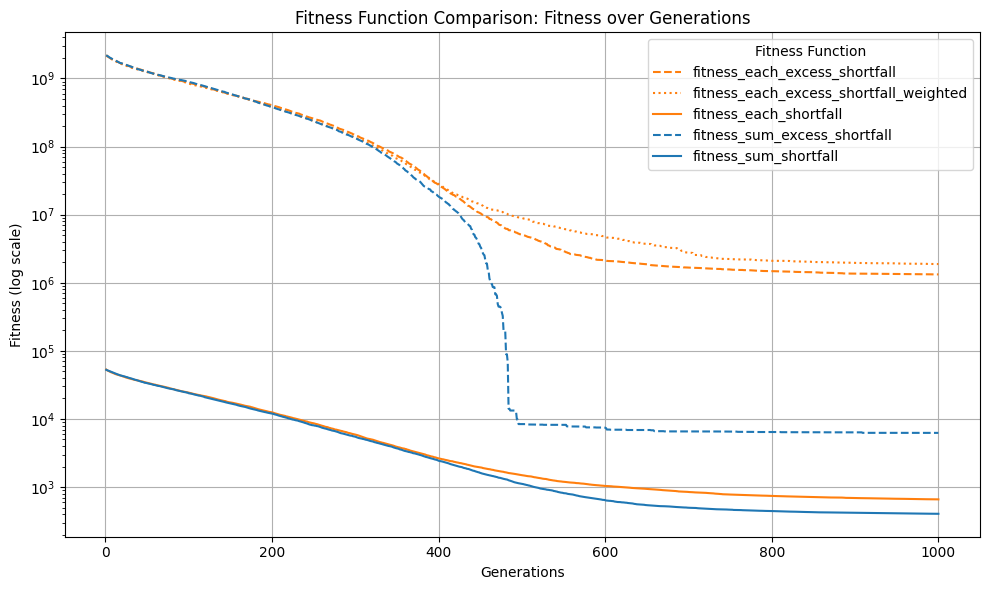

In [8]:
fitness_comparison_graph = (
    fitness_comparison[["fitness_func", "run", "generation", "fitness"]]
    .groupby(["fitness_func", "generation"])
    .fitness.mean()
    .reset_index()
)

custom_palette = {
    "fitness_each_excess_shortfall": ("tab:orange", "--"),
    "fitness_each_excess_shortfall_weighted": ("tab:orange", ":"),
    "fitness_each_shortfall": ("tab:orange", "-"),
    "fitness_sum_excess_shortfall": ("tab:blue", "--"),
    "fitness_sum_shortfall": ("tab:blue", "-"),
}

# Plotting with seaborn and log scale
plt.figure(figsize=(10, 6))

for category, (color, line_style) in custom_palette.items():
    sns.lineplot(
        x="generation",
        y="fitness",
        data=fitness_comparison_graph[
            fitness_comparison_graph["fitness_func"] == category
        ],
        color=color,
        linestyle=line_style,
        markersize=4,  # Adjust marker size
        label=category,
    )

plt.yscale("log")  # Apply logarithmic scale to y-axis

plt.title("Fitness Function Comparison: Fitness over Generations")
plt.xlabel("Generations")
plt.ylabel("Fitness (log scale)")
plt.grid(True)
plt.legend(title="Fitness Function")
plt.tight_layout()

plt.savefig("../Report/images/visualizations/fitness_comparison.svg", format="svg")
plt.show()

In [9]:
get_stats(df=fitness_comparison, var_of_interest="fitness_func")

                                             Anova Results:

                 df                 sum_sq               mean_sq      F  PR(>F)
fitness_func   4.00 1833951302034303488.00 458487825508575872.00 671.31    0.00
Residual     145.00   99031980097176944.00    682979173083978.88    NaN     NaN


                                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                                            
                group1                                 group2                     meandiff    p-adj       lower           upper      reject
-------------------------------------------------------------------------------------------------------------------------------------------
         fitness_each_excess_shortfall fitness_each_excess_shortfall_weighted   -4436961.1417  0.965  -23076947.4066   14203025.1233  False
         fitness_each_excess_shortfall                 fitness_each_shortfall -228421141.0274    0.0 -247061127.2923 -209781154.7624   Tr

In [10]:
solution_appraisal(df=fitness_comparison, var_of_interest="fitness_func")

,fitness,food variety,nutrient_excess,nutrient_shortage
fitness_func,,,,
fitness_sum_shortfall,405.27,20.97,26836.97,-22666.10
fitness_each_shortfall,659.88,26.40,64187.72,-3.74
fitness_sum_excess_shortfall,6247.61,49.57,13339.48,-7605.90
fitness_each_excess_shortfall,1326581.02,46.07,3008.44,-1852.10
fitness_each_excess_shortfall_weighted,1881894.01,44.97,6632.97,-458.52


# 2. Crossover Operator Analysis

In [11]:
crossover_comparison = pd.read_csv("./xo__comparison.csv")
crossover_comparison = calculate_excess_shortage(crossover_comparison)

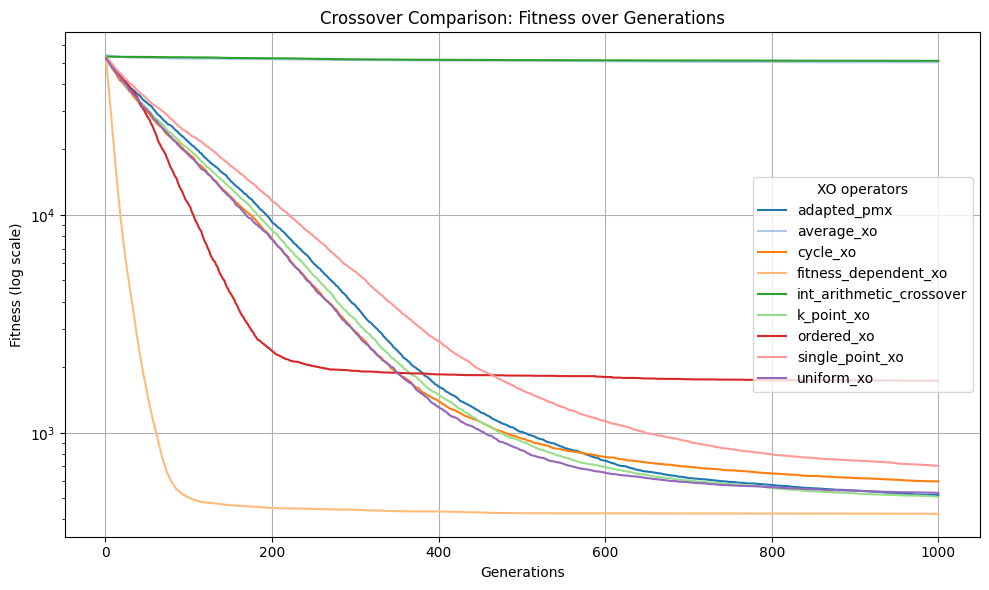

In [12]:
get_viz(
    df=crossover_comparison,
    var_of_interest="xo",
    title="Crossover Comparison: Fitness over Generations",
    legend_title="XO operators",
    output_file_name="xo_comparison",
    scale="log",
)

In [13]:
get_stats(df=crossover_comparison, var_of_interest="xo")

                                             Anova Results:

             df          sum_sq        mean_sq       F  PR(>F)
xo         8.00 100298763244.73 12537345405.59 8910.99    0.00
Residual 261.00    367214740.62     1406953.03     NaN     NaN


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
         group1                   group2            meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------------------------------------------
             adapted_pmx               average_xo  44925.6515    0.0  43967.6521  45883.6508   True
             adapted_pmx                 cycle_xo   -606.2152 0.5592  -1564.2146    351.7841  False
             adapted_pmx     fitness_dependent_xo  -5137.4385    0.0  -6095.4379  -4179.4392   True
             adapted_pmx int_arithmetic_crossover  45455.8958    0.0  44497.8965  46413.8952   True
             adapted_pmx               k_point_x

In [14]:
solution_appraisal(df=crossover_comparison, var_of_interest="xo")

,fitness,food variety,nutrient_excess,nutrient_shortage
xo,,,,
fitness_dependent_xo,424.44,13.67,49190.80,0.00
k_point_xo,507.89,17.50,59715.32,-101.44
adapted_pmx,516.99,18.50,51975.87,-573.26
uniform_xo,529.68,17.83,59881.23,-62.57
cycle_xo,597.97,23.13,49297.05,-27.66
single_point_xo,703.01,27.93,66112.32,-22.84
ordered_xo,1732.50,48.20,41036.04,-887.83
average_xo,50121.05,76.03,2587972.92,0.00
int_arithmetic_crossover,50915.41,76.90,2493057.14,0.00


# 3. Fitness Dependent XO Analysis

In [15]:
dependent_xo = pd.read_csv("./fitness_dependent_comparison.csv")
dependent_xo = calculate_excess_shortage(dependent_xo)
dependent_xo["dependent_xo"] = dependent_xo["Additional info"].apply(
    lambda x: x.get("fitness_dependent_xo_var")
)

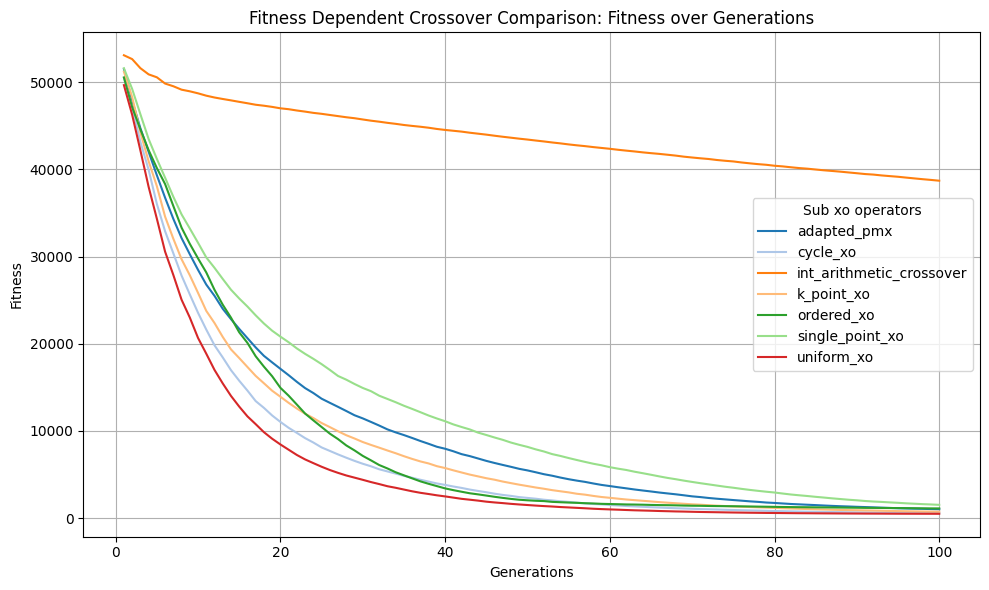

In [53]:
get_viz(
    df=dependent_xo,
    var_of_interest="dependent_xo",
    title="Fitness Dependent Crossover Comparison: Fitness over Generations",
    legend_title="Sub xo operators",
    output_file_name="fit_dependent_crossover_comparison",
    scale="linear",
)

In [54]:
get_stats(df=dependent_xo, var_of_interest="dependent_xo")

                                             Anova Results:

                 df         sum_sq       mean_sq        F  PR(>F)
dependent_xo   6.00 32163238146.51 5360539691.09 10950.74    0.00
Residual     203.00    99371347.92     489514.03      NaN     NaN


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
         group1                   group2            meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------------------------------------------
             adapted_pmx                 cycle_xo  -2937.4179    0.0  -3475.4189  -2399.4168   True
             adapted_pmx int_arithmetic_crossover  33618.5086    0.0  33080.5075  34156.5096   True
             adapted_pmx               k_point_xo  -1607.4435    0.0  -2145.4446  -1069.4425   True
             adapted_pmx               ordered_xo  -1676.7618    0.0  -2214.7628  -1138.7608   True
             adapted_pmx          singl

In [18]:
solution_appraisal(df=dependent_xo, var_of_interest="dependent_xo", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
dependent_xo,,,,
uniform_xo,497.76,17.70,53178.92,0.00
cycle_xo,587.61,22.53,56743.09,-6.40
k_point_xo,737.75,28.53,60746.08,0.00
adapted_pmx,1018.27,36.97,75806.46,0.00
ordered_xo,1115.59,41.30,61606.98,0.00
single_point_xo,1523.91,41.73,96321.84,0.00
int_arithmetic_crossover,38702.90,77.00,2047368.96,0.00


# 4. Population Size Analysis

In [19]:
pop_size = pd.read_csv("./pop_size_comparison.csv")
pop_size = calculate_excess_shortage(pop_size)

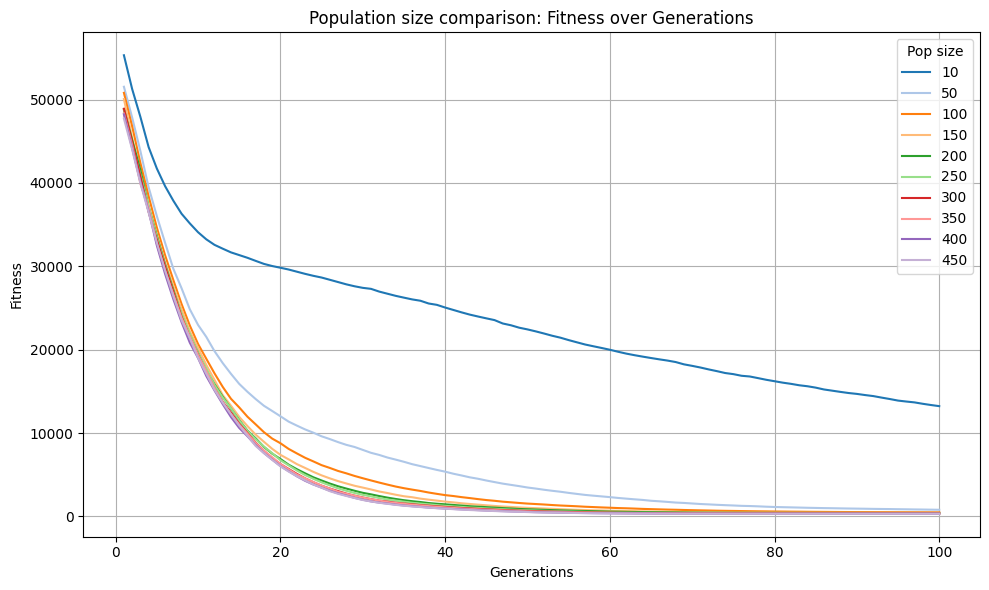

In [20]:
get_viz(
    df=pop_size,
    var_of_interest="pop",
    title="Population size comparison: Fitness over Generations",
    legend_title="Pop size",
    output_file_name="pop_comparison_fitness_vs_generations",
    scale="linear",
)

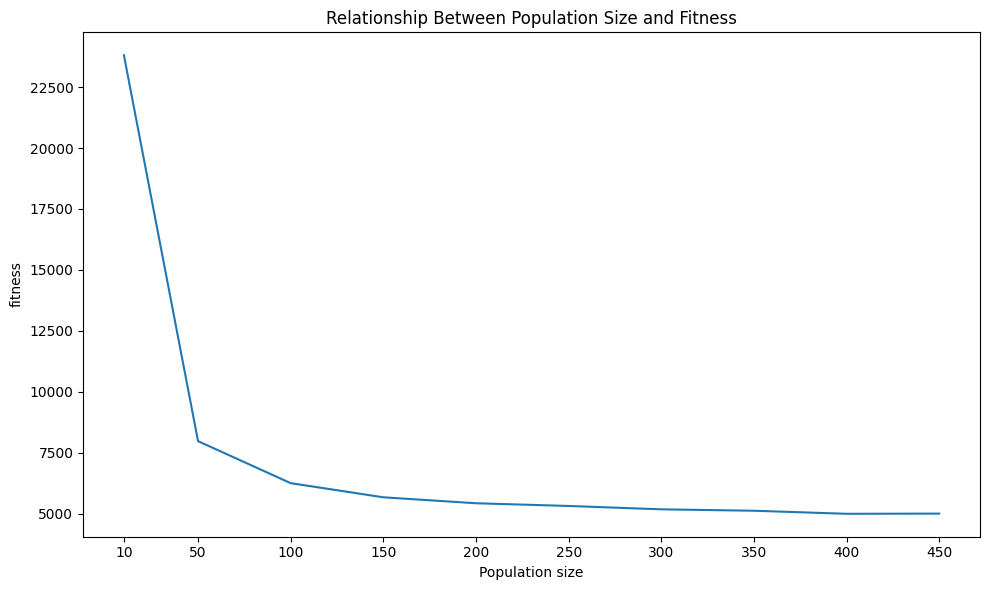

In [21]:
df = (
    pop_size[["pop", "run", "generation", "fitness"]]
    .groupby(["pop", "generation"])
    .fitness.mean()
    .reset_index()
)

# Plotting with seaborn and log scale
plt.figure(figsize=(10, 6))

sns.lineplot(x="pop", y="fitness", data=df, errorbar=None)


plt.title("Relationship Between Population Size and Fitness")
plt.xlabel("Population size")
plt.xticks(ticks=pop_size["pop"].value_counts().index.sort_values(ascending=True))
plt.tight_layout()

plt.savefig(
    f"../Report/images/visualizations/pop_comparison_fitness_vs_pop_size.svg",
    format="svg",
)
plt.show()

In [22]:
get_stats(df=pop_size, var_of_interest="pop")

                                             Anova Results:

             df        sum_sq       mean_sq      F  PR(>F)
pop        1.00 3383984393.69 3383984393.69 171.46    0.00
Residual 298.00 5881293924.55   19735885.65    NaN     NaN


      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
    10     50 -15834.9981    0.0 -16429.5383  -15240.458   True
    10    100 -17559.1293    0.0 -18153.6695 -16964.5891   True
    10    150 -18139.4009    0.0 -18733.9411 -17544.8607   True
    10    200 -18383.4882    0.0 -18978.0284  -17788.948   True
    10    250  -18494.788    0.0 -19089.3282 -17900.2479   True
    10    300 -18632.5658    0.0  -19227.106 -18038.0256   True
    10    350 -18690.7302    0.0 -19285.2703   -18096.19   True
    10    400 -18816.2129    0.0 -19410.7531 -18221.6727   True
    10    450 -18808.6757    0.0 -19403.2159 -18214.1355

In [23]:
solution_appraisal(df=pop_size, var_of_interest="pop", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
pop,,,,
450,320.26,8.83,49805.18,-0.00
400,329.44,8.77,49837.01,0.00
350,334.27,9.20,47650.72,-0.00
250,360.51,10.43,47225.31,0.00
300,361.75,10.43,47391.60,-0.00
200,415.25,13.63,47136.74,0.00
150,430.14,14.07,56735.22,0.00
100,495.61,18.13,53566.78,0.00
50,802.02,26.53,60455.16,0.00


# 5. XO Probability Analysis

In [24]:
xo_prob = pd.read_csv("./xo_proba_comparison.csv")
xo_prob = calculate_excess_shortage(xo_prob)

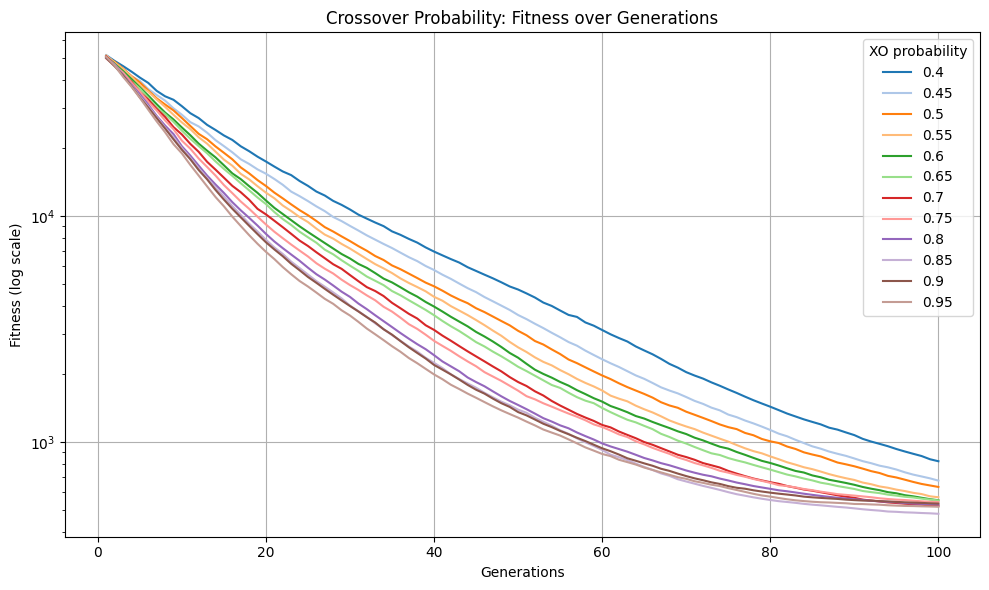

In [25]:
get_viz(
    df=xo_prob,
    var_of_interest="xo_prob",
    title="Crossover Probability: Fitness over Generations",
    legend_title="XO probability",
    output_file_name="xo_proba__comparison_fitness_vs_generations",
    scale="log",
)

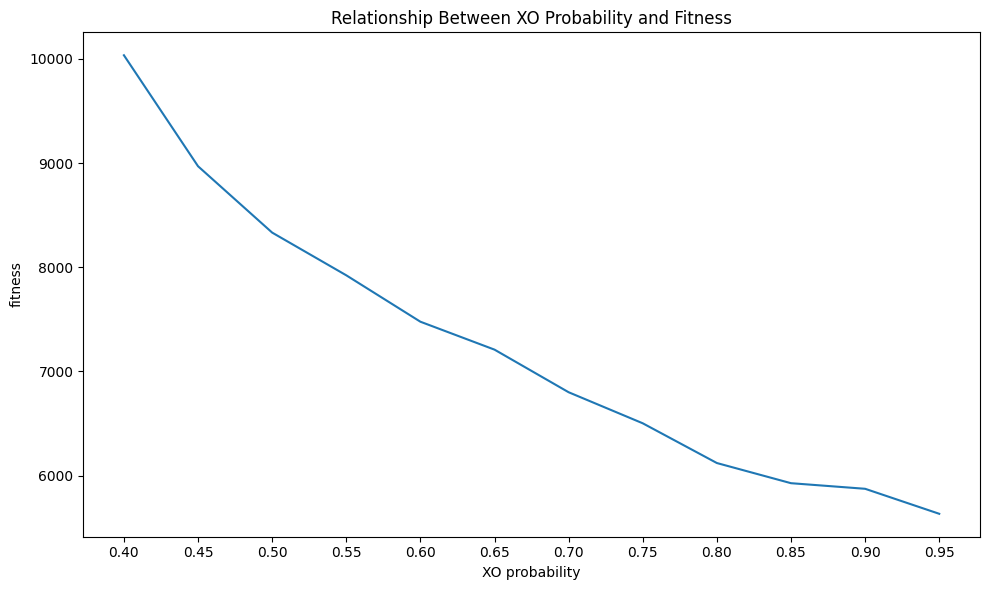

In [26]:
df = (
    xo_prob[["xo_prob", "run", "generation", "fitness"]]
    .groupby(["xo_prob", "generation"])
    .fitness.mean()
    .reset_index()
)

# Plotting with seaborn and log scale
plt.figure(figsize=(10, 6))

sns.lineplot(x="xo_prob", y="fitness", data=df, errorbar=None)


plt.title("Relationship Between XO Probability and Fitness")
plt.xlabel("XO probability")
plt.xticks(ticks=xo_prob["xo_prob"].value_counts().index.sort_values(ascending=True))
plt.tight_layout()

plt.savefig(
    "../Report/images/visualizations/xo_proba__comparison_fitness_vs_proba.svg",
    format="svg",
)
plt.show()

In [27]:
get_stats(df=xo_prob, var_of_interest="xo_prob")

                                             Anova Results:

             df       sum_sq      mean_sq       F  PR(>F)
xo_prob    1.00 583517878.34 583517878.34 2181.90    0.00
Residual 358.00  95741867.29    267435.38     NaN     NaN


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
   0.4   0.45 -1065.4676    0.0 -1414.1476  -716.7876   True
   0.4    0.5 -1702.5336    0.0 -2051.2136 -1353.8536   True
   0.4   0.55 -2112.5186    0.0 -2461.1986 -1763.8386   True
   0.4    0.6 -2558.0905    0.0 -2906.7705 -2209.4105   True
   0.4   0.65  -2826.145    0.0  -3174.825  -2477.465   True
   0.4    0.7 -3235.1646    0.0 -3583.8446 -2886.4846   True
   0.4   0.75 -3533.3009    0.0 -3881.9809 -3184.6209   True
   0.4    0.8 -3914.7528    0.0 -4263.4328 -3566.0728   True
   0.4   0.85 -4108.3344    0.0 -4457.0144 -3759.6544   True
   0.4    0.9 -4162.0272    0.0

In [28]:
solution_appraisal(df=xo_prob, var_of_interest="xo_prob", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
xo_prob,,,,
0.85,480.76,17.33,49155.01,0.00
0.95,516.55,17.80,55926.42,-0.00
0.70,520.51,19.43,58155.79,-0.00
0.80,528.43,19.27,52655.49,0.00
0.90,533.46,18.97,49169.22,-0.15
0.75,542.10,19.30,54677.73,0.00
0.65,550.69,20.30,58412.79,0.00
0.60,551.89,21.50,50933.57,-0.07
0.55,569.06,22.23,52669.22,0.00


# 5. Tournament Size Analysis

In [29]:
tournament_size = pd.read_csv("./tournament_size_comparison.csv")
tournament_size = calculate_excess_shortage(tournament_size)
tournament_size["tour_size"] = tournament_size["Additional info"].apply(
    lambda x: x.get("tour_size")
)

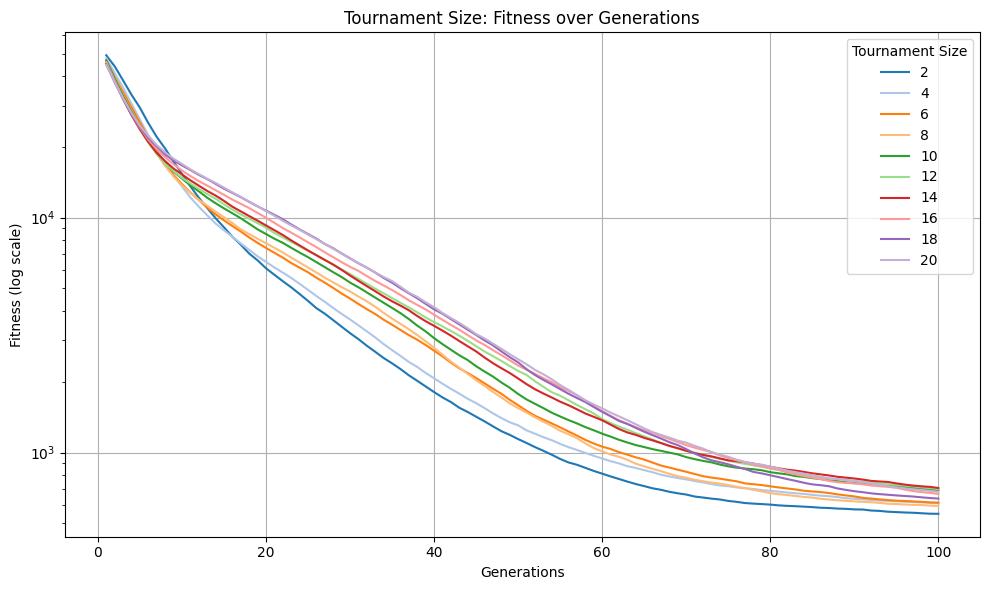

In [30]:
get_viz(
    df=tournament_size,
    var_of_interest="tour_size",
    title="Tournament Size: Fitness over Generations",
    legend_title="Tournament Size",
    output_file_name="tournament_size__comparison_fitness_vs_generations",
    scale="log",
)

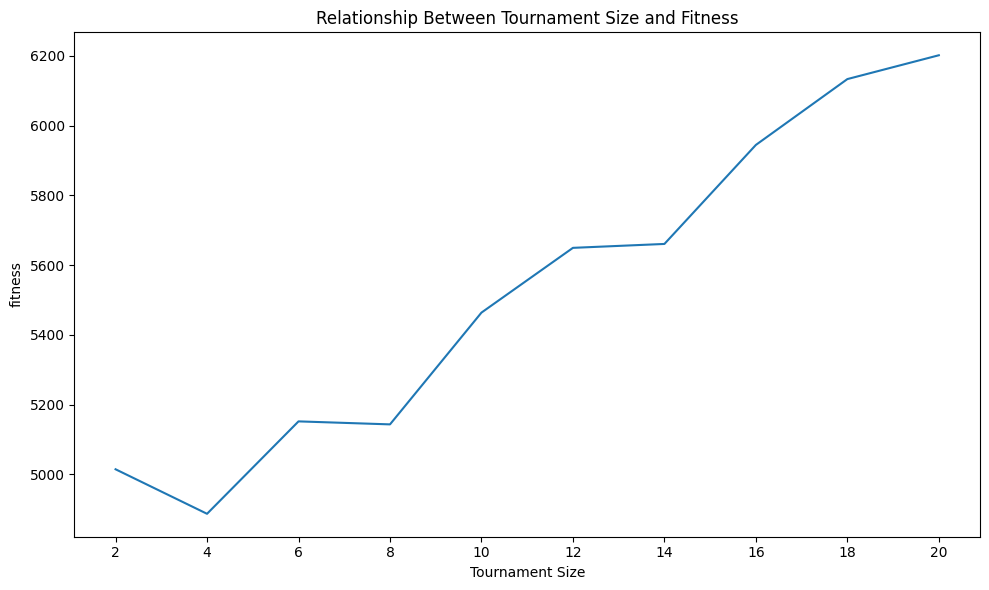

In [31]:
df = (
    tournament_size[["tour_size", "run", "generation", "fitness"]]
    .groupby(["tour_size", "generation"])
    .fitness.mean()
    .reset_index()
)

# Plotting with seaborn and log scale
plt.figure(figsize=(10, 6))

sns.lineplot(x="tour_size", y="fitness", data=df, errorbar=None)


plt.title("Relationship Between Tournament Size and Fitness")
plt.xlabel("Tournament Size")
plt.xticks(
    ticks=tournament_size["tour_size"].value_counts().index.sort_values(ascending=True)
)
plt.tight_layout()

plt.savefig(
    "../Report/images/visualizations/tournament_size__comparison_fitness_vs_tour_size.svg",
    format="svg",
)
plt.show()

In [32]:
get_stats(df=tournament_size, var_of_interest="tour_size")

                                             Anova Results:

              df      sum_sq     mean_sq      F  PR(>F)
tour_size   1.00 57313306.55 57313306.55 216.48    0.00
Residual  298.00 78895224.85   264749.08    NaN     NaN


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     2      4 -127.6374  0.994 -550.1713  294.8964  False
     2      6  137.3171 0.9898 -285.2167   559.851  False
     2      8  128.7214 0.9936 -293.8124  551.2552  False
     2     10  449.2145 0.0271   26.6806  871.7483   True
     2     12  634.8534 0.0001  212.3195 1057.3872   True
     2     14  646.0521 0.0001  223.5183 1068.5859   True
     2     16  929.9664    0.0  507.4326 1352.5003   True
     2     18 1118.7269    0.0  696.1931 1541.2608   True
     2     20 1187.0292    0.0  764.4954 1609.5631   True
     4      6  264.9546 0.6001 -157.5793  687.4884  False
     4      8  

In [33]:
solution_appraisal(df=tournament_size, var_of_interest="tour_size", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
tour_size,,,,
2,548.56,18.97,65989.47,0.00
8,592.05,18.53,100126.79,-0.00
4,608.79,20.43,103304.20,0.00
6,611.85,21.37,80377.97,-0.00
18,636.86,18.53,97336.26,-7.27
16,666.21,20.87,95925.59,0.00
20,680.50,20.93,106838.34,0.00
10,691.36,22.67,119881.78,0.00
12,699.38,24.47,106113.29,-0.00


# 6. Selection Method Analysis

In [34]:
selection_comparison = pd.read_csv("./selection_comparison.csv")
selection_comparison = calculate_excess_shortage(selection_comparison)

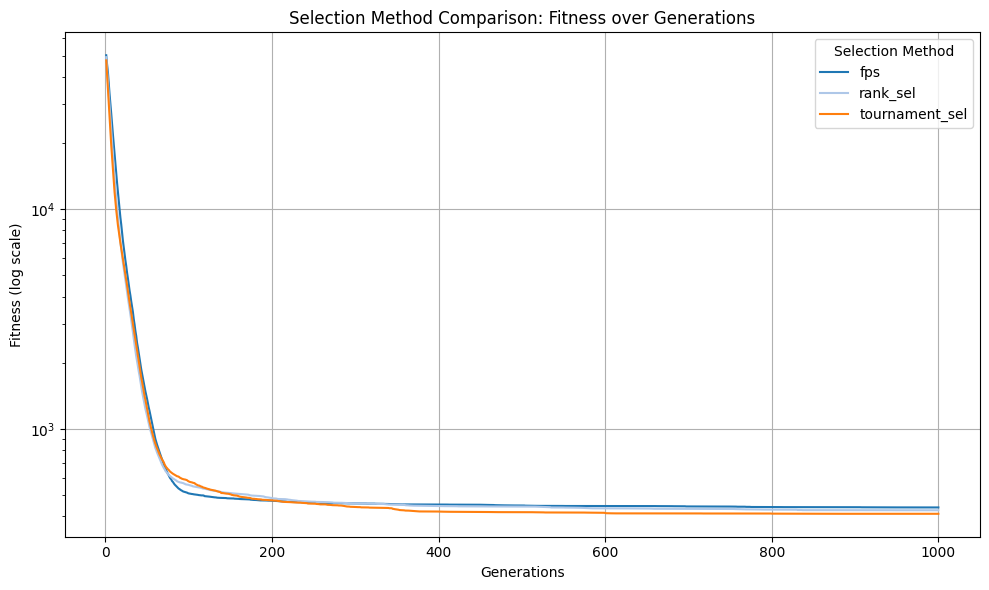

In [35]:
get_viz(
    df=selection_comparison,
    var_of_interest="selection",
    title="Selection Method Comparison: Fitness over Generations",
    legend_title="Selection Method",
    output_file_name="selection_comparison",
    scale="log",
)

In [36]:
get_stats(df=selection_comparison, var_of_interest="selection")

                                             Anova Results:

             df    sum_sq   mean_sq     F  PR(>F)
selection  2.00 257960.60 128980.30 40.34    0.00
Residual  87.00 278152.11   3197.15   NaN     NaN


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1      group2      meandiff p-adj    lower    upper   reject
------------------------------------------------------------------
     fps       rank_sel   -87.556    0.0 -122.3681  -52.744   True
     fps tournament_sel -128.3267    0.0 -163.1388 -93.5147   True
rank_sel tournament_sel  -40.7707 0.0175  -75.5828  -5.9587   True
------------------------------------------------------------------


In [37]:
solution_appraisal(df=selection_comparison, var_of_interest="selection")

,fitness,food variety,nutrient_excess,nutrient_shortage
selection,,,,
tournament_sel,410.69,11.37,85743.05,0.00
rank_sel,426.17,13.23,63939.64,0.00
fps,438.97,13.87,52726.27,0.00


# 7. Mutation Operator Analysis

In [38]:
mutation_comparison = pd.read_csv("./mutation_comparison.csv")
mutation_comparison = calculate_excess_shortage(mutation_comparison)

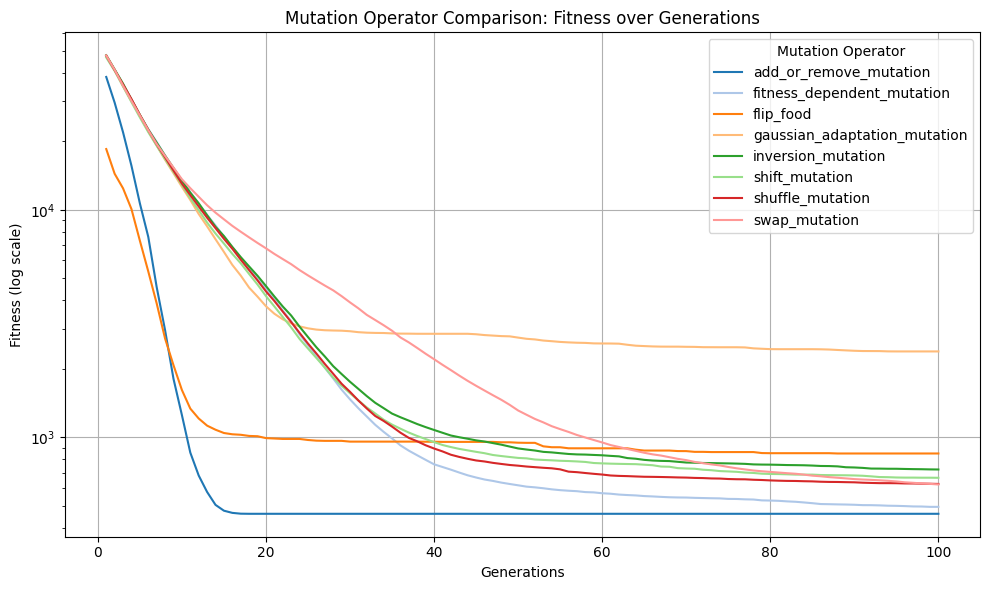

In [39]:
get_viz(
    df=mutation_comparison,
    var_of_interest="mutation",
    title="Mutation Operator Comparison: Fitness over Generations",
    legend_title="Mutation Operator",
    output_file_name="mutation_comparison",
    scale="log",
)

In [40]:
get_stats(df=mutation_comparison, var_of_interest="mutation")

                                             Anova Results:

             df       sum_sq     mean_sq      F  PR(>F)
mutation   7.00 409745778.24 58535111.18 533.61    0.00
Residual 232.00  25449552.04   109696.34    NaN     NaN


                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
           group1                       group2             meandiff  p-adj    lower      upper    reject
--------------------------------------------------------------------------------------------------------
      add_or_remove_mutation   fitness_dependent_mutation  2377.6025    0.0  2116.0231  2639.1818   True
      add_or_remove_mutation                    flip_food  -151.6598 0.6387  -413.2391   109.9195  False
      add_or_remove_mutation gaussian_adaptation_mutation  3672.0968    0.0  3410.5174  3933.6761   True
      add_or_remove_mutation           inversion_mutation  2594.4107    0.0  2332.8313    2855.99   True
      add_or_remove_mutation      

In [41]:
solution_appraisal(df=mutation_comparison, var_of_interest="mutation", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
mutation,,,,
add_or_remove_mutation,461.22,3.77,114453.50,0.00
fitness_dependent_mutation,494.80,18.57,59835.64,0.00
swap_mutation,620.60,22.07,82557.45,-0.00
shuffle_mutation,623.99,20.23,47640.40,-0.00
shift_mutation,664.07,21.70,43900.37,0.00
inversion_mutation,722.29,18.20,50571.97,-0.00
flip_food,849.39,8.07,147832.30,-0.00
gaussian_adaptation_mutation,2387.07,26.20,237622.93,0.00


# 8. Mutation Propability Analysis

In [42]:
mutation_prob_comparison = pd.read_csv("./mutation_prob_comparison.csv")
mutation_prob_comparison = calculate_excess_shortage(mutation_prob_comparison)

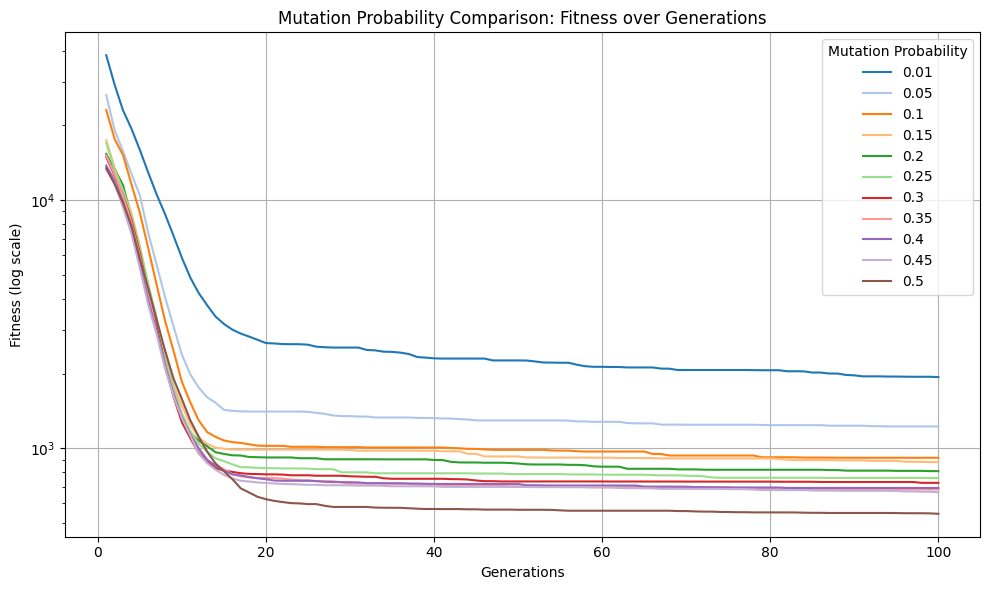

In [43]:
get_viz(
    df=mutation_prob_comparison,
    var_of_interest="mut_prob",
    title="Mutation Probability Comparison: Fitness over Generations",
    legend_title="Mutation Probability",
    output_file_name="mutation_prob_comparison",
    scale="log",
)

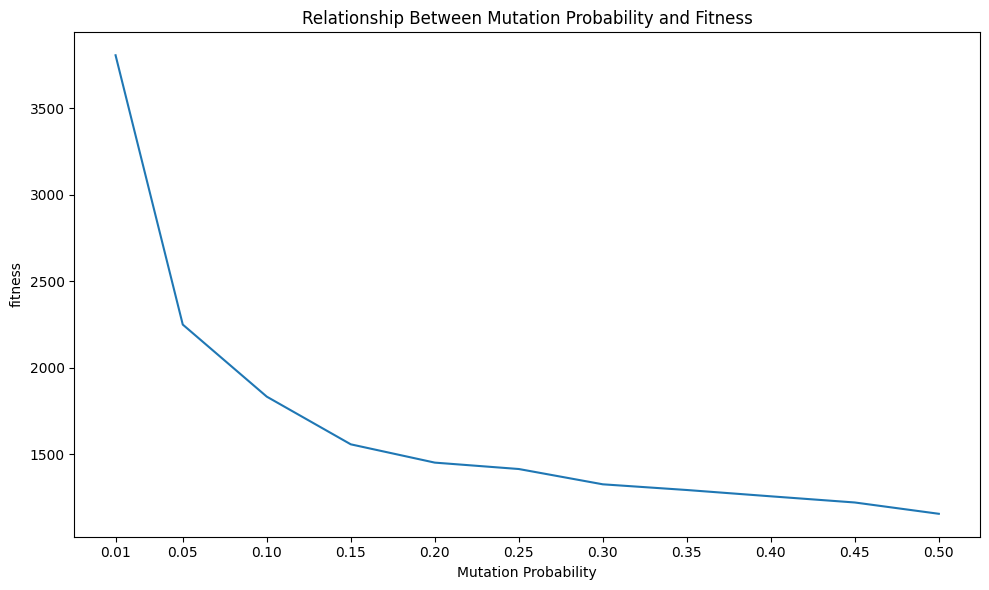

In [50]:
df = (
    mutation_prob_comparison[["mut_prob", "run", "generation", "fitness"]]
    .groupby(["mut_prob", "generation"])
    .fitness.mean()
    .reset_index()
)

# Plotting with seaborn and log scale
plt.figure(figsize=(10, 6))

sns.lineplot(x="mut_prob", y="fitness", data=df, errorbar=None)


plt.title("Relationship Between Mutation Probability and Fitness")
plt.xlabel("Mutation Probability")
plt.xticks(
    ticks=mutation_prob_comparison["mut_prob"]
    .value_counts()
    .index.sort_values(ascending=True)
)
plt.tight_layout()

plt.savefig(
    "../Report/images/visualizations/mutation_prob_fitness_vs_prob_size.svg",
    format="svg",
)
plt.show()

In [44]:
get_stats(df=mutation_prob_comparison, var_of_interest="mut_prob")

                                             Anova Results:

             df       sum_sq      mean_sq      F  PR(>F)
mut_prob   1.00 103641173.27 103641173.27 274.24    0.00
Residual 328.00 123959548.50    377925.45    NaN     NaN


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
  0.01   0.05 -1556.3847    0.0 -1885.6226 -1227.1468   True
  0.01    0.1 -1972.8704    0.0 -2302.1083 -1643.6325   True
  0.01   0.15 -2248.4242    0.0 -2577.6621 -1919.1863   True
  0.01    0.2 -2354.1069    0.0 -2683.3448  -2024.869   True
  0.01   0.25 -2391.0663    0.0 -2720.3042 -2061.8284   True
  0.01    0.3 -2479.4654    0.0 -2808.7033 -2150.2275   True
  0.01   0.35 -2512.3751    0.0  -2841.613 -2183.1372   True
  0.01    0.4 -2548.8328    0.0 -2878.0707 -2219.5949   True
  0.01   0.45 -2584.4985    0.0 -2913.7364 -2255.2606   True
  0.01    0.5 -2649.8512    0.0 -2

In [45]:
solution_appraisal(df=mutation_prob_comparison, var_of_interest="mut_prob", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
mut_prob,,,,
0.50,545.29,7.13,196979.45,0.00
0.45,665.72,6.40,177874.37,0.00
0.35,682.79,5.50,105679.23,0.00
0.40,692.87,6.27,131920.06,0.00
0.30,726.56,8.27,174696.44,-0.00
0.25,759.58,5.80,115512.73,0.00
0.20,809.97,6.30,97386.09,0.00
0.15,880.52,8.73,171594.03,0.00
0.10,916.69,8.17,144896.17,0.00


# 9. Elitism Analysis

In [46]:
elitism = pd.read_csv("./elitism_comparison.csv")
elitism = calculate_excess_shortage(elitism)

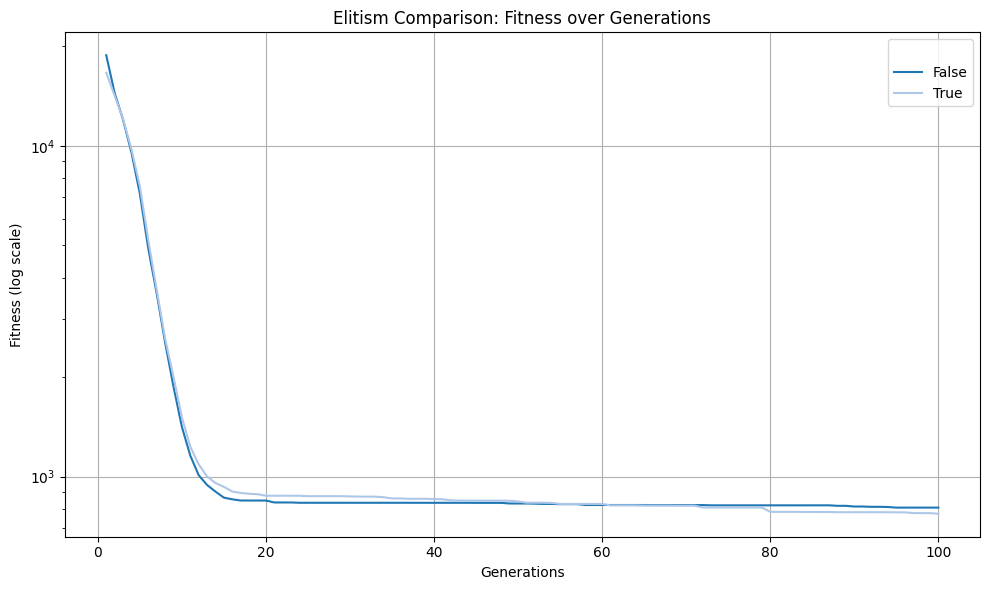

In [47]:
get_viz(
    df=elitism,
    var_of_interest="elitism",
    title="Elitism Comparison: Fitness over Generations",
    legend_title=" ",
    output_file_name="elitism_comparison",
    scale="log",
)

In [52]:
groups = elitism["elitism"].unique()
data = {group: elitism["fitness"][elitism["elitism"] == group] for group in groups}
t_stat, p_val = ttest_ind(data[groups[0]], data[groups[1]])

print(f"                         t-Test Results \n")
print(f"t-statistic: {t_stat}\np-value: {p_val}")

                         t-Test Results 

t-statistic: 0.07039376807142313
p-value: 0.9438825980683059


In [49]:
solution_appraisal(df=elitism, var_of_interest="elitism", gen=100)

,fitness,food variety,nutrient_excess,nutrient_shortage
elitism,,,,
True,772.02,8.03,152911.51,0.00
False,806.01,6.33,108214.57,0.00
